In [1]:
import matplotlib.pyplot as plt
import random
from matplotlib import colors

In [2]:
class Game():
    '''
    board = 6x7 numpy array
    - = empty
    Y = player 1 (yellow)
    R = player 2 (red), computer

    '''

    def __init__(self):
        self.board = [
            ['-','-','-','-','-','-','-'],
            ['-','-','-','-','-','-','-'],
            ['-','-','-','-','-','-','-'],
            ['-','-','-','-','-','-','-'],
            ['-','-','-','-','-','-','-'],
            ['-','-','-','-','-','-','-'],
        ]
    
    def isValidMove(self, column:int) -> bool:
        # ToDo
        if self.board[0][column] == '-':
            return True
        else:
            return False

    def play(self, player:str, column:int):
        
        if not self.isValidMove(column=column):
            return 'invalid move!'
        
        column_values = [row[column] for row in game.board]
        row = max([i for i,v in enumerate(column_values) if v=='-']) # the row to which the chip will fall
        self.board[row][column] = player
        return 

    @staticmethod
    def plotBoard(board):
        mapping = {'-': 0, 'Y': 1, 'R': 2}
        boardColors = []
        for row in game.board:
            boardColors.append([mapping[v] for v in row])

        # make a color map of fixed colors
        cmap = colors.ListedColormap(['gray', 'yellow', 'red'])
        bounds=[0,0.5,1.5,2]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        fig, ax = plt.subplots()
        c = ax.pcolor(boardColors, edgecolors='k', linewidths=4, cmap=cmap, norm=norm)
        ax.invert_yaxis()
        #ax.set_axis_off()
        ax.set_aspect('equal')
        return ax

    @staticmethod
    def fourInARow(row, col, board):
        '''
        '''
        if board[row][col] == '-':
            return None
        
        # vertical down: 
        if row < len(board)-3:
            if (board[row][col] == board[row+1][col] == board[row+2][col] == board[row+3][col]):
                return board[row][col]
        
        # horizontal right:
        if col < len(board[0])-3:
            if (board[row][col] == board[row][col+1] == board[row][col+2] == board[row][col+3]):
                return board[row][col]

        # right diag: 
        if (row < len(board)-3) & (col < len(board[0])-3):
            if (board[row][col] == board[row+1][col+1] == board[row+2][col+2] == board[row+3][col+3]):
                return board[row][col]

        # left diag: 
        if (row < len(board)-3) & (col > 2):
            if (board[row][col] == board[row+1][col-1] == board[row+2][col-2] == board[row+3][col-3]):
                return board[row][col]
        return None


    def checkWin(self, board):
        '''
        '''
        for row in range(len(board)):
            for col in range(len(board[0])):
                winner = self.fourInARow(row, col, board)
                if winner:
                    return winner
        return winner


Winner: R


[]

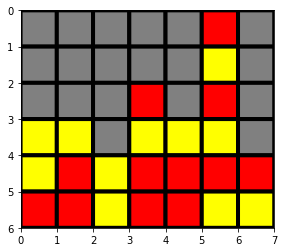

In [3]:
game = Game()
player = 'Y'
winner = None
while not winner:
    move = random.choice(range(7))
    #print(f'Player: {player}, Move: {move}')

    game.play(player=player, column=move)
    winner = game.checkWin(game.board)

    # switch players
    player = {'Y': 'R', 'R': 'Y'}.get(player) 

print(f'Winner: {winner}')
ax = game.plotBoard(game.board)
ax.plot()